In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
plt.rcParams.update({'font.size': 16})
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.stats import skew
plt.rcParams.update({'font.size': 16})

In [2]:
nn_depth  = 4
nn_width  = 256
batchSize =  256
option3 = False
option4 = True
channels = ["C32", "C33", "C34", "C35", "C36"]

In [3]:
from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")

#quantiles = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95])

#quantiles = np.array([ 0.03, 0.16, 0.5, 0.84, 0.97])
quantiles = np.array([0.002, 0.03, 0.16, 0.5, 0.84, 0.97, 0.998])
inChannels = ['C34', 'C41', 'C42', 'C43']

### read input data
(change file paths here)

In [4]:
from aws_test_data import awsTestData
nn_depth = 4
nn_width = 128
channel  = "C34"

filename = "option4_qrnn_models_3sigma/qrnn_%s_%s_%s.nc" % (str(nn_depth), str(nn_width), str(channel))
print (filename)
qrnn = QRNN.load(filename)

inChannels = [channel, 'C41', 'C42', 'C43', 'C44']
test_data = awsTestData("/home/inderpreet/Dendrite/Projects/AWS-325GHz/TB_AWS/testing_data_noise_four.nc", 
               inChannels, option = 4)

option4_qrnn_models_3sigma/qrnn_4_128_C34.nc
[4, 8, 9, 10, 11]


[268.4118  267.84253 267.64886 ... 261.93747 261.5069  260.54315]


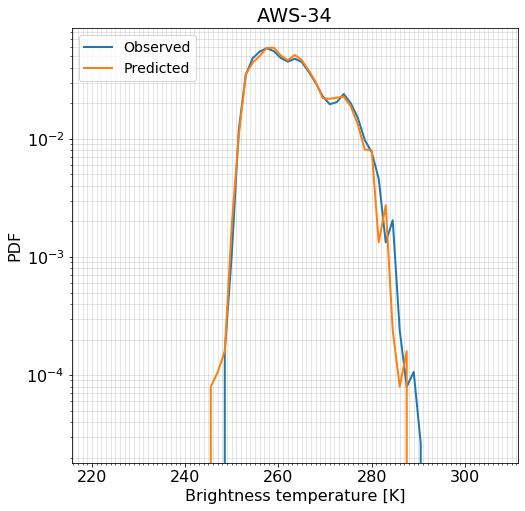

In [5]:


x = (test_data.x - test_data.mean)/test_data.std
y_pre = qrnn.predict(x.data)
y0 = test_data.y0
y_prior = test_data.x[:, 0]

y_pos_mean = qrnn.posterior_mean(x.data)

print (y_prior)
bins = np.arange(220, 310, 1.5)

hist = np.histogram(y_pos_mean, bins, density = True)
histpr = np.histogram(y_prior, bins, density= True)
hist0 = np.histogram(y0, bins, density = True)

fig, ax = plt.subplots(1, 1,figsize = [8,8])
ax.plot(bins[:-1], hist[0], linewidth = 2.0)
ax.plot(bins[:-1], hist0[0], linewidth = 2.0)
#    ax.plot(bins[:-1], histpr[0])
ax.set_yscale('log')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'both', alpha = 0.4)
ax.set_ylabel("PDF")

ax.set_xlabel('Brightness temperature [K]')
ax.legend(["Observed", "Predicted"], loc = 'upper left', prop={'size': 14})
ax.set_title("AWS-%s"%str(channel[1:]))
fig.savefig('Figures/distribution_predicted_%s.png'%(channel), bbox_inches='tight')

## Uncertainty Estimation
#### The quantiles given by QRNN describe the uncertainty of each prediction. Uncertainty will vary from case to case, some (cases are cloudy and some are clear)

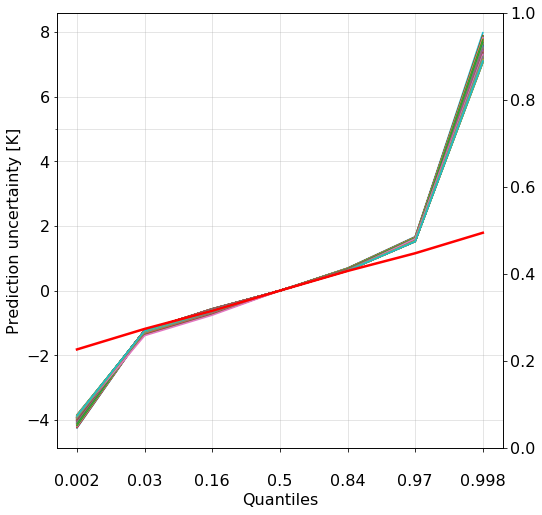

In [19]:
fig, ax = plt.subplots(1, 1, figsize = [8, 8])
x = np.arange(-3, 4, 1)
ii = 0
for i in range(0, 24000, 100):
    ii +=1
#for i in ind:
    y1 = y_pre[i,  :] - y_pre[i, 3]
    
    ax.plot(x, y1)

ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.grid(which = 'both', alpha = 0.4)

ax.set_xlabel("Quantiles")
ax.set_ylabel("Prediction uncertainty [K]")
ax.set_xticks(x)
ax.set_xticklabels((r'$3\sigma$', r'$2\sigma$', r'$1\sigma$', 0,r'$1\sigma$', r'$2\sigma$', r'$3\sigma$'), va='center')


q_prior = np.quantile(y_prior, quantiles, axis = 0)
#ax.plot(x, q_prior - q_prior[3])

q0 = np.quantile(y0, quantiles, axis = 0)
#ax.plot(x, q0 - q0[3])

y_normal = np.random.normal(270, 0.62, 24000)
q_normal = np.quantile(y_normal, quantiles , axis = 0)
ax.plot(x, q_normal - q_normal[3], 'r', linewidth = 2.5)
ax.tick_params(axis='x', which='major', pad=10)

ax2 = ax.twinx()
ax.set_xticks(x)
ax.set_xticklabels(quantiles)
ax.tick_params(axis='x', which='major', pad=30)

fig.savefig('Figures/prediction_uncertainty.png')



In [7]:
#n_intervals = quantiles.size // 2
n_intervals = 4
qs = quantiles
intervals = np.array([q_r - q_l for (q_l, q_r)
                      in zip(qs, reversed(qs))])[:n_intervals]
counts = np.zeros(n_intervals)

print(intervals, n_intervals)

total = 0.0
for i in range(n_intervals):
    l = y_pre[:, [i]]
    r = y_pre[:, [-(i + 1)]]
    counts[i] += np.logical_and(y0 >= l, y0 < r).sum()

#total += np.prod(y0.size())

#intervals[::-1], (counts / total)[::-1]
counts

[0.996 0.94  0.68  0.   ] 4


array([2.63889583e+08, 7.15463310e+07, 3.16224420e+07, 0.00000000e+00])

100


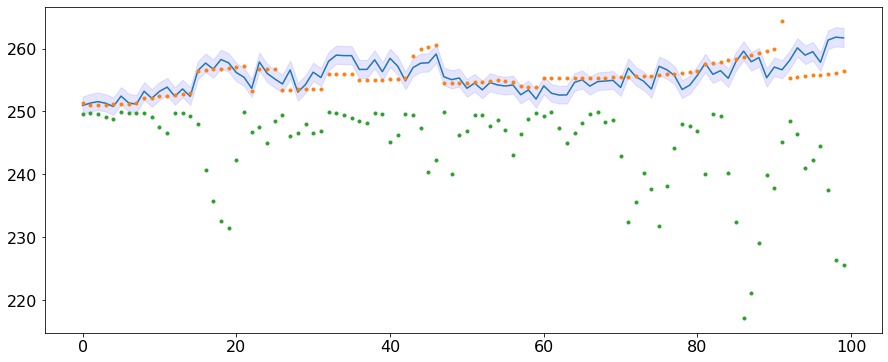

In [8]:
mask = np.random.randint(0, 24000, 100)
mask
mask = np.where(y_prior < 250.0)[0][1:101]
print(len(mask))

y_pre_1 = y_pre[mask, 1]
y_pre_2 = y_pre[mask, 5]
yy0     = y0[mask]
y_p     = y_pos_mean[mask]
y_in    = y_prior[mask]
x = np.arange(0, len(mask), 1)

fig, ax = plt.subplots(1,1, figsize = [15,6])
ax.plot(y_p)
ax.plot(yy0, '.')
ax.plot(y_in, '.')
ax.fill_between(x, y_pre_1, y_pre_2, color='b', alpha=.1)


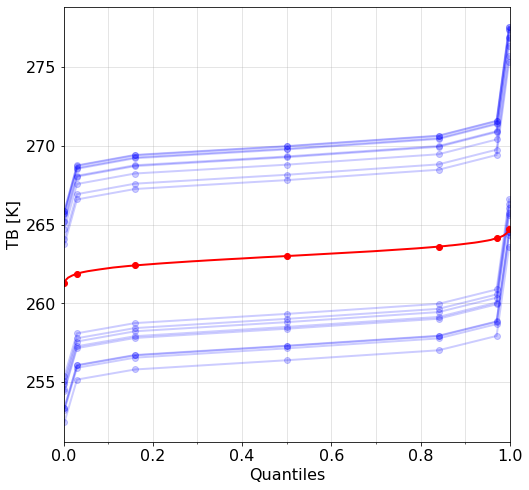

In [9]:
fig, ax = plt.subplots(1, 1, figsize = [8,8])
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.grid(which = 'both', alpha = 0.4)

d = []
j = 12000
mask = np.where(y_prior < 260.0)[0][1:101]
for i in mask[1:10]:
#    d.append(y_pre[:, i])
#    q_pre = np.array(d)  
#    q_pre = np.mean(q_pre, axis = 1)
    ax.plot(quantiles, y_pre[i, :], '-bo', alpha = 0.2,  linewidth = 2)
mask = np.where(y_prior > 250.0)[0][1:101]
for i in mask[1:10]:
#    d.append(y_pre[:, i])
#    q_pre = np.array(d)  
#    q_pre = np.mean(q_pre, axis = 1)
    ax.plot(quantiles, y_pre[i, :], '-bo', alpha = 0.2,  linewidth = 2)
y_normal = np.random.normal(263, 0.60, 24000)
quantiles1 = np.arange(0.001, 1, 0.001)
q_normal = np.quantile(y_normal, quantiles1 , axis = 0)
ax.plot(quantiles1, q_normal, 'r', linewidth = 2)

q_normal = np.quantile(y_normal, quantiles , axis = 0)
ax.plot(quantiles, q_normal, 'ro', linewidth = 2)

#q_prior = np.quantile(y_prior, quantiles1, axis = 0)
#ax.plot(quantiles1, q_prior, 'g', linewidth = 2)

#q_prior = np.quantile(y_prior, quantiles, axis = 0)
#ax.plot(quantiles, q_prior, 'go')
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=1)
ax.set_xlabel('Quantiles')
ax.set_ylabel('TB [K]')
fig.savefig('Figures/quantile_function_C34.png')